# GCaMP8s vs GCaMP8m in PV+ interneurons

In [1]:
import numpy as np
import scipy, os, sys

# physion should be installed with "pip install physion"
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'physion', 'src'))
import physion
import physion.utils.plot_tools as pt

# data folder:
DATA_folder = os.path.join(os.path.expanduser('~'), 'DATA/CIBELE/PV_dendrites_V1/test2024/')

In [2]:
DATASET ={}
for key in ['GCamP8M', 'GCamP8S']:
    DATASET[key] = \
           physion.analysis.read_NWB.scan_folder_for_NWBfiles(os.path.join(DATA_folder, key), verbose=False)

/home/yann.zerlaut/miniconda3/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [3]:
for key in ['GCamP8M', 'GCamP8S']:
    print('\n'+10*'-'+' '+key+' '+10*'-')
    for i, f in enumerate(DATASET[key]['files']):
        print('- sessionID %.2d : %s' % (i, os.path.basename(f)))


---------- GCamP8M ----------
- sessionID 00 : 2024_03_05-13-41-39.nwb
- sessionID 01 : 2024_03_05-14-00-11.nwb
- sessionID 02 : 2024_03_05-14-19-33.nwb
- sessionID 03 : 2024_03_05-14-33-55.nwb
- sessionID 04 : 2024_03_05-14-49-29.nwb
- sessionID 05 : 2024_03_05-15-27-33.nwb
- sessionID 06 : 2024_03_08-10-59-53.nwb
- sessionID 07 : 2024_03_08-11-14-21.nwb
- sessionID 08 : 2024_03_08-11-37-42.nwb
- sessionID 09 : 2024_03_08-11-53-42.nwb
- sessionID 10 : 2024_03_08-12-11-14.nwb
- sessionID 11 : 2024_03_08-12-26-26.nwb
- sessionID 12 : 2024_03_08-12-40-12.nwb
- sessionID 13 : 2024_03_08-12-55-46.nwb

---------- GCamP8S ----------
- sessionID 00 : 2024_03_13-16-44-08.nwb
- sessionID 01 : 2024_03_22-14-35-26.nwb
- sessionID 02 : 2024_03_25-14-28-16.nwb
- sessionID 03 : 2024_03_25-15-23-50.nwb
- sessionID 04 : 2024_03_25-15-49-26.nwb
- sessionID 05 : 2024_03_25-16-16-14.nwb
- sessionID 06 : 2024_03_25-16-41-58.nwb
- sessionID 07 : 2024_03_26-15-19-42.nwb
- sessionID 08 : 2024_03_26-16-16-20

# Computing Responses

In [4]:
Nmax = 1000

##################################################
########### PARAMETERS OF THE ANALYSIS ###########
##################################################
INTERVALS = {
            'GCamP8M':{'pre':[-0.5,0.], 'post':[0.,0.5]},
            'GCamP8S':{'pre':[-1.5,0.], 'post':[0.,1.5]},
              }
significance_threshold = 0.05 # for the evoked response shift (with respect to baseline)
test_for_significance = 'ttest' # type of statistical test used, either: ttest, wilcoxon, anova
##################################################

MODALITIES = ['running_speed', 'facemotion', 'pupil_size', 'gaze_motion']

for key in ['GCamP8M', 'GCamP8S']:
    
    DATASET[key]['nSessions'] = 0
    DATASET[key]['nROIs'] = []
    DATASET[key]['cResp'] = [[] for c in range(8)]
    DATASET[key]['significant-positive-ROIS'] = [[] for c in range(8)]
    DATASET[key]['significant-negative-ROIS'] = [[] for c in range(8)]
    DATASET[key]['deflect-positive-ROIS'] = [[] for c in range(8)]
    DATASET[key]['deflect-negative-ROIS'] = [[] for c in range(8)]

    for mod in MODALITIES:
        DATASET[key][mod] = []
    
    for f, filename in enumerate(DATASET[key]['files'][:Nmax]):
        
        DATASET[key]['nSessions'] += 1
        for mod in MODALITIES:
            DATASET[key][mod].append([])
        
        for c in range(8):
            DATASET[key]['significant-positive-ROIS'][c].append([])
            DATASET[key]['significant-negative-ROIS'][c].append([])
            DATASET[key]['deflect-positive-ROIS'][c].append([])
            DATASET[key]['deflect-negative-ROIS'][c].append([])
            DATASET[key]['cResp'][c].append([])

        data = physion.analysis.read_NWB.Data(filename,
                                              verbose=False)
        data.build_dFoF(verbose=False)
        DATASET[key]['nROIs'].append(data.nROIs)

        ########################################################
        #######.   correlation with behavior       #############
        ########################################################

        for mod, func in zip(MODALITIES, 
                             [data.build_running_speed, data.build_facemotion,
                              data.build_pupil_diameter, data.build_gaze_movement]):
            # build:
            modality = func(specific_time_sampling=data.t_dFoF)
            # then corrcoef with all ROIs
            for roi in range(data.nROIs):
                DATASET[key][mod][-1].append(np.corrcoef(data.dFoF[roi,:], 
                                                         modality)[0,1])
                
        ########################################################
        #######.   stimulus-evoked activity        #############
        ########################################################
        
        episodes = physion.analysis.process_NWB.EpisodeData(data, 
                                                            quantities=['dFoF'],
                                                            prestim_duration=3.,
                                                            protocol_id=0,
                                                            verbose=False)
        
        
        contrasts = np.unique(episodes.contrast)
        # loop over contrast levels
        for c, contrast in enumerate(contrasts):
            cond = (episodes.angle==90) &\
                        (episodes.contrast==contrast)
            
            # loop over ROIs
            for roi in range(episodes.dFoF.shape[1]):
                
                dFoF = np.mean(episodes.dFoF[cond,roi,:], axis=0)
                DATASET[key]['cResp'][c][f].append(dFoF-np.mean(dFoF[(episodes.t>-0.5) & (episodes.t<0)]))
                
                stats = episodes.stat_test_for_evoked_responses(response_args={'roiIndex':roi},
                                                                episode_cond=cond,
                                                                interval_pre=INTERVALS['GCamP8M']['pre'],
                                                                interval_post=INTERVALS['GCamP8M']['post'],
                                                                test=test_for_significance,
                                                                positive=True,
                                                                verbose=True)
                deflect = np.mean(stats.y-stats.x)
                if (stats.pvalue<significance_threshold) and (deflect>0):
                    DATASET[key]['significant-positive-ROIS'][c][f].append(roi)
                    DATASET[key]['deflect-positive-ROIS'][c][f].append(deflect)
                elif (stats.pvalue<significance_threshold):
                    # negative deflect
                    DATASET[key]['significant-negative-ROIS'][c][f].append(roi)
                    DATASET[key]['deflect-negative-ROIS'][c][f].append(deflect)
                
    DATASET[key]['contrasts'] = contrasts
    DATASET[key]['t'] = episodes.t

# Stimulus-Evoked Activity

## Plot Stimulus-Evoked activity average across all cells (Grand-Average)

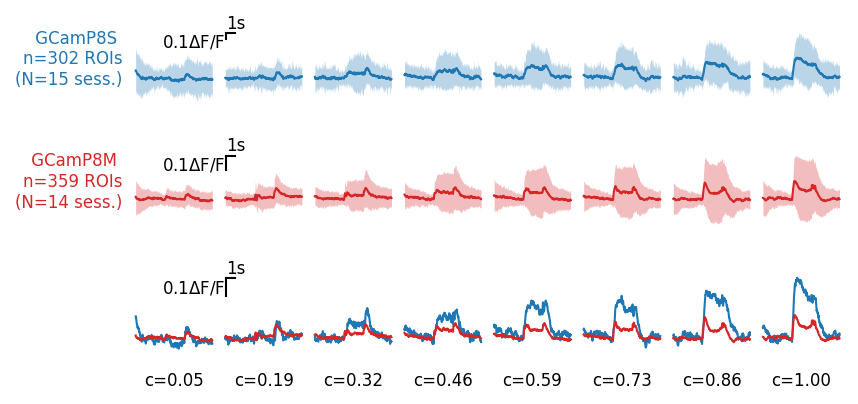

In [6]:
fig, AX = pt.figure(axes=(len(contrasts),3), figsize=(.8,.8),wspace=0.1)

COLORS = ['tab:blue', 'tab:red']

for k, key in enumerate(['GCamP8S', 'GCamP8M']):

    for c, contrast in enumerate(DATASET[key]['contrasts']):

        allResps = np.concatenate([r for r in DATASET[key]['cResp'][c] if len(r)>0])
        pt.plot(DATASET[key]['t'], np.mean(allResps, axis=0), 
                sy=np.std(allResps, axis=0),
                color=COLORS[k], ax=AX[k][c])
        
        AX[2][c].plot(DATASET[key]['t'], np.mean(allResps, axis=0), color=COLORS[k])
        
    pt.annotate(AX[k][0], ' %s  \nn=%i ROIs \n(N=%i sess.) ' % (key,
                                                                 np.sum(DATASET[key]['nROIs']),
                                                                 DATASET[key]['nSessions']),
               (-0.05,1), va='top', ha='right', color=COLORS[k])
    
for c, contrast in enumerate(DATASET[key]['contrasts']):
    pt.annotate(AX[2][c], '\nc=%.2f' % contrast, (0.5,0.), va='top', ha='center')
        
for k in range(3):
    for c in range(8):
        AX[k][c].axis('off')
    pt.set_common_ylims(AX[k])
    pt.draw_bar_scales(AX[k][1], Xbar=1, Xbar_label='1s', Ybar=0.1, Ybar_label='0.1$\\Delta$F/F')
#fig.savefig(os.path.expanduser('~'), 'Desktop', 'fig.svg')

## Evaluate positive and negative responses

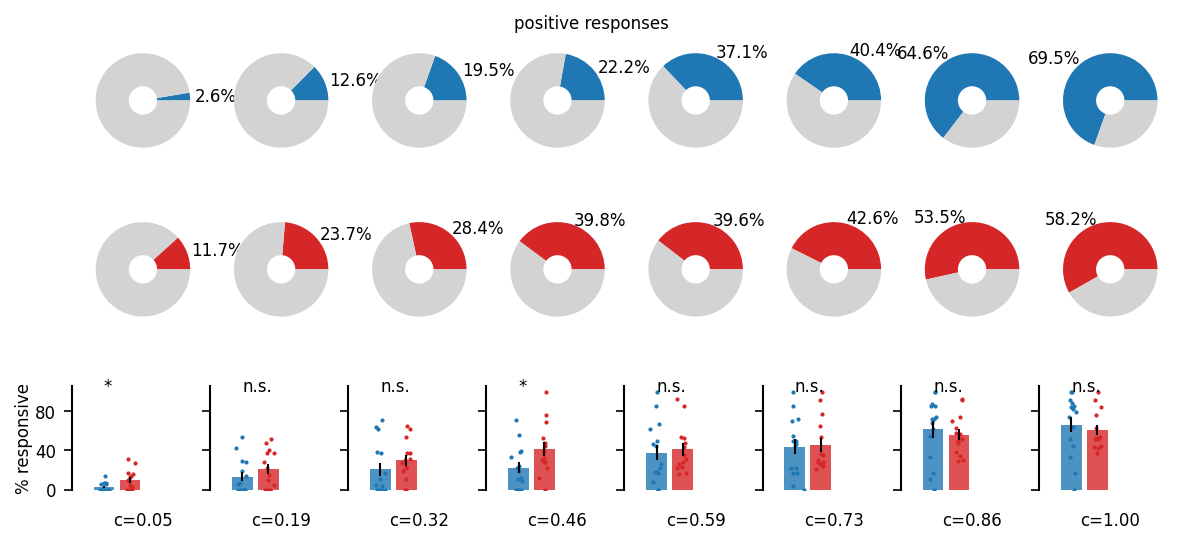

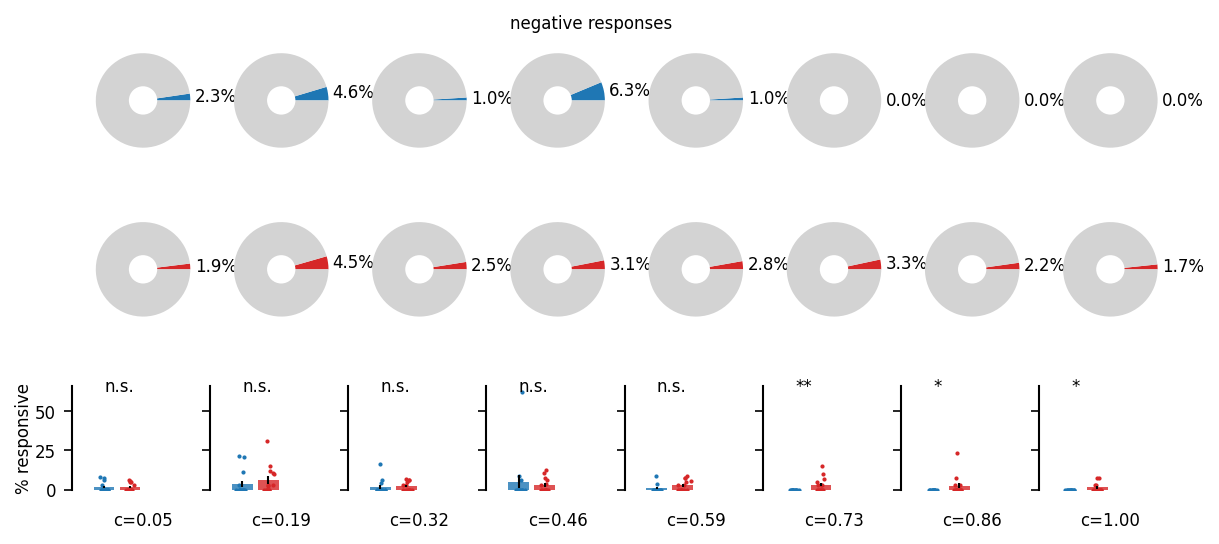

In [7]:
COLORS = ['tab:blue', 'tab:red']

for deflect in ['positive', 'negative']:
    
    fig, AX = pt.figure(axes=(len(contrasts),3), figsize=(1, 1.1),wspace=0.1)
    fig.suptitle('%s responses' % deflect)
    
    FRACS = {}
    for k, key in enumerate(['GCamP8S', 'GCamP8M']):
        FRACS[key] = []
        for c, contrast in enumerate(DATASET[key]['contrasts']):
    
    
            nPos = np.sum([len(X) for X in DATASET[key]['significant-%s-ROIS' % deflect][c]])
            nTots = np.sum(DATASET[key]['nROIs'])
    
            pt.pie([100.*(nPos/nTots), 100.*(1-nPos/nTots)], 
                   COLORS=[COLORS[k], 'lightgrey'],
                   ext_labels= ['%.1f%%' % (100.*(nPos/nTots)), ''],
                   ax=AX[k][c])
    
            FRACS[key].append([1.*len(p)/t for (p, t) in\
                                   zip(DATASET[key]['significant-%s-ROIS' % deflect][c], DATASET[key]['nROIs'])])
    
            AX[2][c].scatter(k+.1*np.random.randn(len(FRACS[key][-1])),
                             100*np.array(FRACS[key][-1]), s=1,
                             color = COLORS[k])
            
            AX[2][c].bar([k], [100.*np.mean(FRACS[key][-1])], 
                         yerr=[100.*scipy.stats.sem(FRACS[key][-1])], 
                         color = COLORS[k], alpha=.8)
            
        
    for c, contrast in enumerate(DATASET[key]['contrasts']):
        pt.annotate(AX[2][c], '\nc=%.2f' % contrast, (0.5,0.), va='top', ha='center')

    # STATISTICAL TEST
    for c in range(8):
        pt.annotate(AX[2][c],
                    pt.from_pval_to_star(\
                        scipy.stats.mannwhitneyu(FRACS['GCamP8S'][c], FRACS['GCamP8M'][c]).pvalue), 
                        #scipy.stats.ttest_ind(FRACS['GCamP8S'][c], FRACS['GCamP8M'][c]).pvalue), 
                    (0.2,1), va='center')
        for k in range(2):
            AX[k][c].axis('off')
        pt.set_plot(AX[2][c], ['left'], xlim=[-1,4], 
                    ylabel='% responsive' if c==0 else None,
                    yticks_labels=[] if c>0 else None)
    pt.set_common_ylims(AX[2])
    
    fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '%s-responses.svg' % deflect))

In [8]:
dataset = 'GCamP8S'
sessionID = 13
contrast_level_index = 0
print('list of ROI indices significantly modulated:')
print(DATASET[dataset]['significant-positive-ROIS'][contrast_level_index][sessionID])
print( '   @ filename = ', DATASET[key]['files'][sessionID])
print( '   @ contrast = ', contrasts[contrast_level_index])

list of ROI indices significantly modulated:
[26, 29]
   @ filename =  /home/yann.zerlaut/DATA/CIBELE/PV_dendrites_V1/test2024/GCamP8M/NWBs/2024_03_08-12-55-46.nwb
   @ contrast =  0.05


<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2699398/2238409688.py:38: SyntaxWarning: invalid escape sequence '\D'
  pt.draw_bar_scales(AX[k][1], Xbar=1, Xbar_label='1s', Ybar=0.2, Ybar_label='0.2$\Delta$F/F')
/tmp/ipykernel_2699398/2238409688.py:40: SyntaxWarning: invalid escape sequence '\D'
  pt.set_plot(ax2, xlabel='contrast', ylabel='evoked $\Delta$F/F', xticks=[0,0.5,1])
/tmp/ipykernel_2699398/2238409688.py:25: RuntimeWarning: Mean of empty slice
  resps = [[np.nanmean(f) for f in DATASET[key]['deflect-%s-ROIS' % deflect][c]] for c in range(8)]
/home/yann.zerlaut/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yann.zerlaut/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: Run

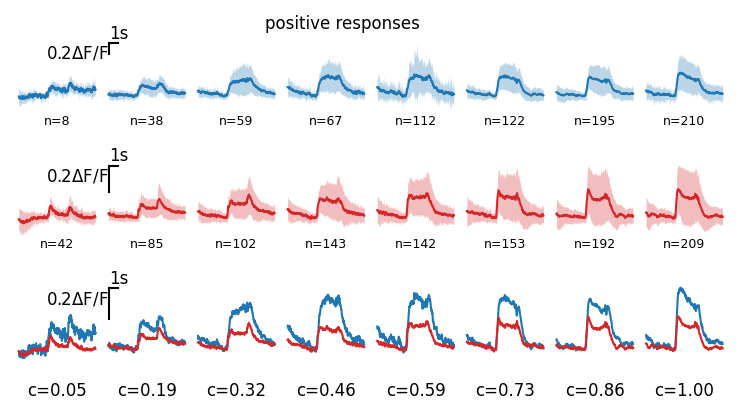

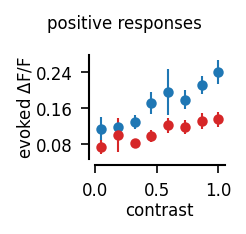

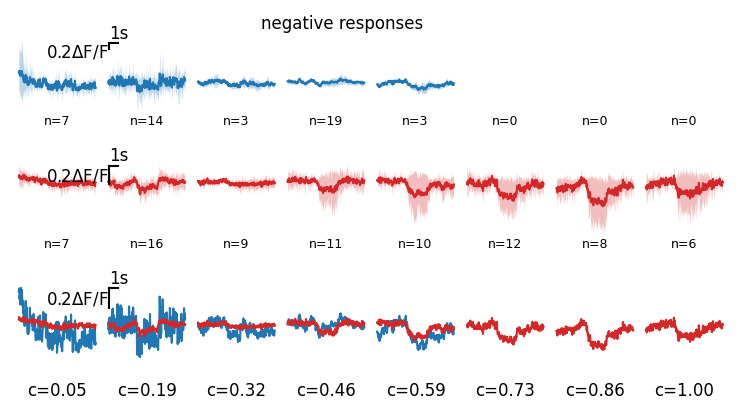

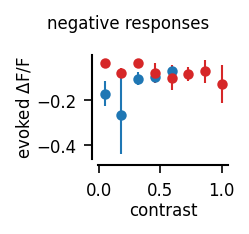

In [9]:

COLORS = ['tab:blue', 'tab:red']

for deflect in ['positive', 'negative']:
    
    fig, AX = pt.figure(axes=(len(contrasts),3), figsize=(.8,.8),wspace=0.1)
    fig.suptitle('%s responses' % deflect)

    fig2, ax2 = pt.figure(figsize=(1.,1.1))
    fig2.suptitle('%s responses' % deflect)
    
    for k, key in enumerate(['GCamP8S', 'GCamP8M']):
    
        for c, contrast in enumerate(DATASET[key]['contrasts']):
    
            indices = DATASET[key]['significant-%s-ROIS' % deflect][c]
            allResps = np.concatenate([np.array(DATASET[key]['cResp'][c][f])[indices]\
                                       for f, indices in enumerate(indices) if len(DATASET[key]['cResp'][c][f])>0])
            pt.plot(DATASET[key]['t'], np.mean(allResps, axis=0), 
                    sy=np.std(allResps, axis=0),
                    color=COLORS[k], ax=AX[k][c])
            
            AX[2][c].plot(DATASET[key]['t'], np.mean(allResps, axis=0), color=COLORS[k])
            pt.annotate(AX[k][c], 'n=%i' % np.sum([len(i) for i in indices]), (0.5,0.), va='top', ha='center', fontsize=6)

        resps = [[np.nanmean(f) for f in DATASET[key]['deflect-%s-ROIS' % deflect][c]] for c in range(8)]
        pt.scatter(DATASET[key]['contrasts'],
                   np.nanmean(resps, axis=1),
                   sy=scipy.stats.sem(resps, axis=1, nan_policy='omit'),
                   color=COLORS[k], ax=ax2)
                 
    for c, contrast in enumerate(DATASET[key]['contrasts']):
        pt.annotate(AX[2][c], '\nc=%.2f' % contrast, (0.5,0.), va='top', ha='center')
            
    for k in range(3):
        for c in range(8):
            AX[k][c].axis('off')
        pt.set_common_ylims(AX[k])
        pt.draw_bar_scales(AX[k][1], Xbar=1, Xbar_label='1s', Ybar=0.2, Ybar_label='0.2$\Delta$F/F')

    pt.set_plot(ax2, xlabel='contrast', ylabel='evoked $\Delta$F/F', xticks=[0,0.5,1])
    fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '%s-traces.svg' % deflect))
    fig2.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '%s-contrast-dep.svg' % deflect))

/tmp/ipykernel_750320/2238409688.py:25: RuntimeWarning: Mean of empty slice
  resps = [[np.nanmean(f) for f in DATASET[key]['deflect-%s-ROIS' % deflect][c]] for c in range(8)]


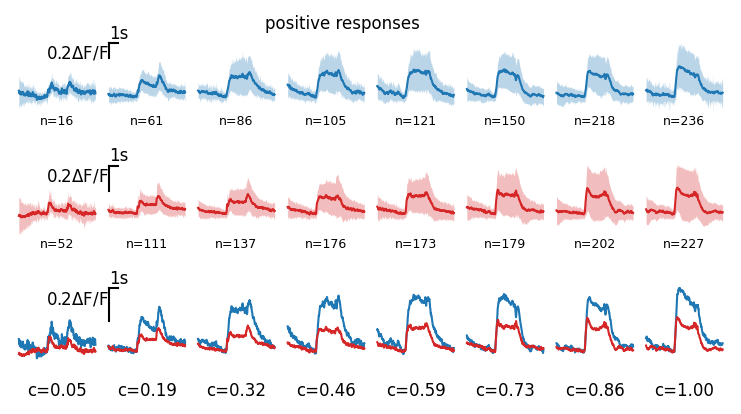

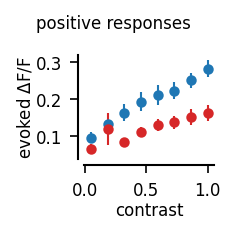

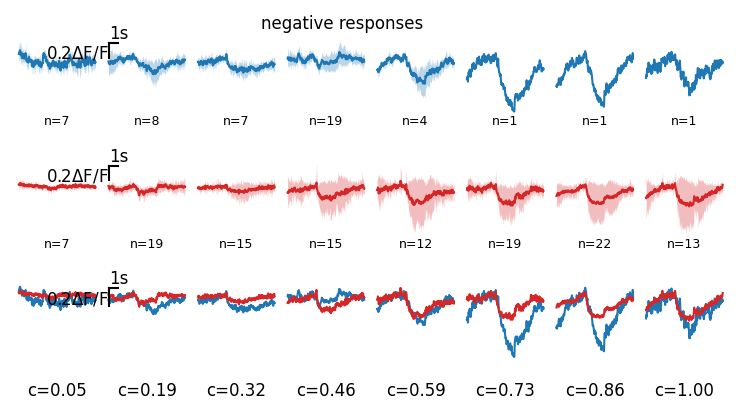

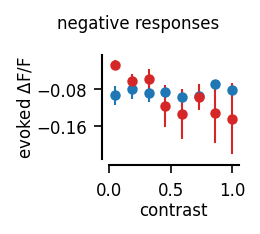

In [8]:

COLORS = ['tab:blue', 'tab:red']

for deflect in ['positive', 'negative']:
    
    fig, AX = pt.figure(axes=(len(contrasts),3), figsize=(.8,.8),wspace=0.1)
    fig.suptitle('%s responses' % deflect)

    fig2, ax2 = pt.figure(figsize=(1.,1.1))
    fig2.suptitle('%s responses' % deflect)
    
    for k, key in enumerate(['GCamP8S', 'GCamP8M']):
    
        for c, contrast in enumerate(DATASET[key]['contrasts']):
    
            indices = DATASET[key]['significant-%s-ROIS' % deflect][c]
            allResps = np.concatenate([np.array(DATASET[key]['cResp'][c][f])[indices]\
                                       for f, indices in enumerate(indices) if len(DATASET[key]['cResp'][c][f])>0])
            pt.plot(DATASET[key]['t'], np.mean(allResps, axis=0), 
                    sy=np.std(allResps, axis=0),
                    color=COLORS[k], ax=AX[k][c])
            
            AX[2][c].plot(DATASET[key]['t'], np.mean(allResps, axis=0), color=COLORS[k])
            pt.annotate(AX[k][c], 'n=%i' % np.sum([len(i) for i in indices]), (0.5,0.), va='top', ha='center', fontsize=6)

        resps = [[np.nanmean(f) for f in DATASET[key]['deflect-%s-ROIS' % deflect][c]] for c in range(8)]
        pt.scatter(DATASET[key]['contrasts'],
                   np.nanmean(resps, axis=1),
                   sy=scipy.stats.sem(resps, axis=1, nan_policy='omit'),
                   color=COLORS[k], ax=ax2)
                 
    for c, contrast in enumerate(DATASET[key]['contrasts']):
        pt.annotate(AX[2][c], '\nc=%.2f' % contrast, (0.5,0.), va='top', ha='center')
            
    for k in range(3):
        for c in range(8):
            AX[k][c].axis('off')
        pt.set_common_ylims(AX[k])
        pt.draw_bar_scales(AX[k][1], Xbar=1, Xbar_label='1s', Ybar=0.2, Ybar_label='0.2$\Delta$F/F')

    pt.set_plot(ax2, xlabel='contrast', ylabel='evoked $\Delta$F/F', xticks=[0,0.5,1])
    fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '%s-traces.svg' % deflect))
    fig2.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '%s-contrast-dep.svg' % deflect))

# Correlation with Spontaneous Behavior

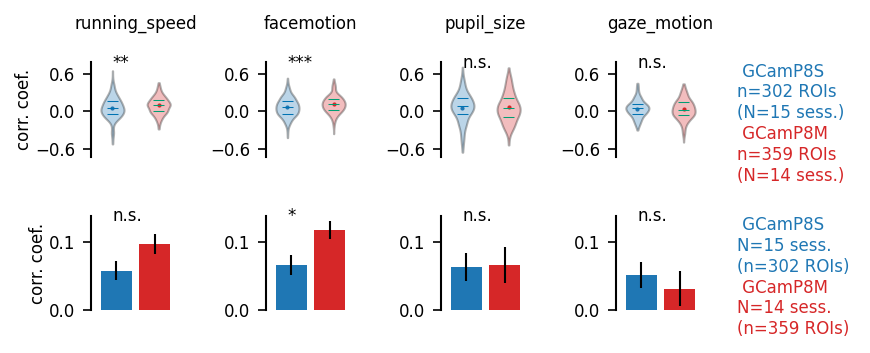

In [10]:
fig, AX = pt.figure(axes=(len(MODALITIES),2), figsize=(.7,1.), wspace=2)

COLORS = ['tab:blue', 'tab:red']

for k, key in enumerate(['GCamP8S', 'GCamP8M']):

    for m, mod in enumerate(MODALITIES):

        # per unit analysis
        allResps = np.concatenate([r for r in DATASET[key][mod]])
        #AX[0][m].bar([k], [np.mean(allResps)], 
        #             yerr=[scipy.stats.sem(allResps)],
        #             color=COLORS[k])

        pt.violin(allResps, x=k, color=COLORS[k], ax=AX[0][m])
        # per session analysis
        allResps = [np.mean(r) for r in DATASET[key][mod]]
        AX[1][m].bar([k], [np.mean(allResps)], 
                     yerr=[scipy.stats.sem(allResps)],
                     color=COLORS[k])

        
        AX[0][m].set_title(mod+'\n')
        
    pt.annotate(AX[0][-1], 3*k*'\n'+' %s  \nn=%i ROIs \n(N=%i sess.) ' % (key,
                                                                 np.sum(DATASET[key]['nROIs']),
                                                                 DATASET[key]['nSessions']),
               (1.5,1), va='top', color=COLORS[k])
    pt.annotate(AX[1][-1], 3*k*'\n'+' %s  \nN=%i sess. \n(n=%i ROIs) ' % (key,
                                                                 DATASET[key]['nSessions'],
                                                                 np.sum(DATASET[key]['nROIs'])),
               (1.5,1), va='top', color=COLORS[k])

for m, mod in enumerate(MODALITIES):
    pt.annotate(AX[0][m],
                pt.from_pval_to_star(\
                    scipy.stats.mannwhitneyu(np.concatenate([r for r in DATASET['GCamP8S'][mod]]),
                                             np.concatenate([r for r in DATASET['GCamP8M'][mod]])\
                                             ).pvalue), 
                    #scipy.stats.ttest_ind(FRACS['GCamP8S'][c], FRACS['GCamP8M'][c]).pvalue), 
                (0.2,1), va='center')
    
for m, mod in enumerate(MODALITIES):
    pt.annotate(AX[1][m],
                pt.from_pval_to_star(\
                    scipy.stats.mannwhitneyu([np.mean(r) for r in DATASET['GCamP8S'][mod]],
                                             [np.mean(r) for r in DATASET['GCamP8M'][mod]]\
                                             ).pvalue), 
                    #scipy.stats.ttest_ind(FRACS['GCamP8S'][c], FRACS['GCamP8M'][c]).pvalue), 
                (0.2,1), va='center')

for ax in AX[0]:
    pt.set_plot(ax, ['left'], #yticks=[0,.1],
                ylabel='corr. coef.' if ax==AX[0][0] else None)
pt.set_common_ylims(AX[0])
for ax in AX[1]:
    pt.set_plot(ax, ['left'], yticks=[0,.1],
                ylabel='corr. coef.' if ax==AX[1][0] else None)
pt.set_common_ylims(AX[1])

#fig.savefig(os.path.expanduser('~'), 'Desktop', 'fig.svg')